# Azure Open AI o1 multi-modal Test
The following sample shows the most basic way to use the o1(GA) with Vision model with code.

> ✨ ***Note*** <br>
> Please check the supported models and API version before you get started - https://azure.microsoft.com/en-us/blog/announcing-the-o1-model-in-azure-openai-service-multimodal-reasoning-with-astounding-analysis/?msockid=388843f556c46b710353575a57e66a9a

## Prerequisites
Configure a Python virtual environment for 3.10 or later: 
 1. open the Command Palette (Ctrl+Shift+P).
 1. Search for Python: Create Environment.
 1. select Venv / Conda and choose where to create the new environment.
 1. Select the Python interpreter version. Create with version 3.10 or later.

For a dependency installation, run the code below to install the packages required to run it. 

```bash
pip install -r requirements.txt
```

## Set up your environment
Git clone the repository to your local machine. 

```bash
git clone https://github.com/hyogrin/Azure_OpenAI_samples.git
```

Create an .env file based on the .env-sample file. Copy the new .env file to the folder containing your notebook and update the variables.

## 🔨 Current Support and Limitations (as of 2025-01-06) 
- GA model version is 2024-12-17
- Model o1 is enabled only for api versions **2024-12-01-preview** and later
- Check the region o1 supported - https://learn.microsoft.com/en-us/azure/cognitive-services/openai/reference#o1-modelsopen ai rest
- Check the API version o1 supported - https://learn.microsoft.com/en-us/azure/ai-services/openai/reference-preview

In [19]:
%load_ext autoreload
%autoreload 2

import os, sys
module_path = "../util"
sys.path.append(os.path.abspath(module_path))

from common import check_kernel
check_kernel()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Kernel: python31015jvsc74a57bd07fae5fd5097eba353202a8ff671bfdb53a1767393571418b923386fbe14d03af


## 🧪 o1 multimodal with image url 

In [20]:
import os
import json
from openai import AzureOpenAI
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential, EnvironmentCredential
from azure.keyvault.secrets import SecretClient
load_dotenv(override=True)

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
#azure_openai_key = os.getenv("AZURE_OPENAI_KEY", "") if len(os.getenv("AZURE_OPENAI_KEY", "")) > 0 else None
azure_openai_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
azure_openai_embedding_deployment = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-ada-002")
aoai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "") if len(os.getenv("AZURE_OPENAI_API_VERSION", "")) > 0 else None
kv_secret_name = os.getenv("KEY_VAULT_SECRET_NAME")
tenant_id = os.getenv("AZURE_TENANT_ID")


# Use DefaultAzureCredential to authenticate with Azure Key Vault
# credential = DefaultAzureCredential()
credential = InteractiveBrowserCredential(tenant_id=tenant_id)

key_vault_url = os.getenv("AZURE_KEY_VAULT_URL")
key_vault_secret_name = os.getenv("AZURE_KEY_VAULT_SECRET_NAME")

kv_client = SecretClient(vault_url=key_vault_url, credential=credential)

# Retrieve the OpenAI API key from Key Vault
azure_openai_key = kv_client.get_secret(key_vault_secret_name).value

# Initialize the AzureOpenAI client with the retrieved key
try:
    client = AzureOpenAI(
        azure_endpoint=azure_openai_endpoint,
        api_key=azure_openai_key,
        api_version=aoai_api_version
    )
except (ValueError, TypeError) as e:
    print(e)

In [22]:
response = client.chat.completions.create(
    model=azure_openai_deployment_name,
    messages=[
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": "Describe this picture:" 
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": "https://devblogs.microsoft.com/semantic-kernel/wp-content/uploads/sites/78/2023/09/semantic-kernel-in-prompt-flow-1.png"
                }
            }
        ] } 
    ],
    
)
print(response)
print(response.choices[0].message.content)
print("Usage Information:")
print(f"Cached Tokens: {response.usage.prompt_tokens_details.cached_tokens}")
print(f"Completion Tokens: {response.usage.completion_tokens}")
print(f"Prompt Tokens: {response.usage.prompt_tokens}")
print(f"Total Tokens: {response.usage.total_tokens}")

ChatCompletion(id='chatcmpl-AmdIPxuzTeTTcrVNjX2ojPHVqOFXo', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The diagram is a simple vertical flow chart. At the top is an oval labeled “Benchmark data,” with a downward arrow leading into a rectangular “Prompt flow” container. Inside that container, there are three key steps arranged vertically:\n\n1. A smaller box labeled “Input.”  \n2. A large, rounded rectangle labeled “Semantic Kernel.”  \n3. Another smaller box labeled “Output.”  \n\nFinally, another downward arrow leaves the bottom of the “Prompt flow” container and points to an oval labeled “Results and metrics.”', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False

## 🧪 o1 multimodal with local image (base64 encoding)

Data URL: 

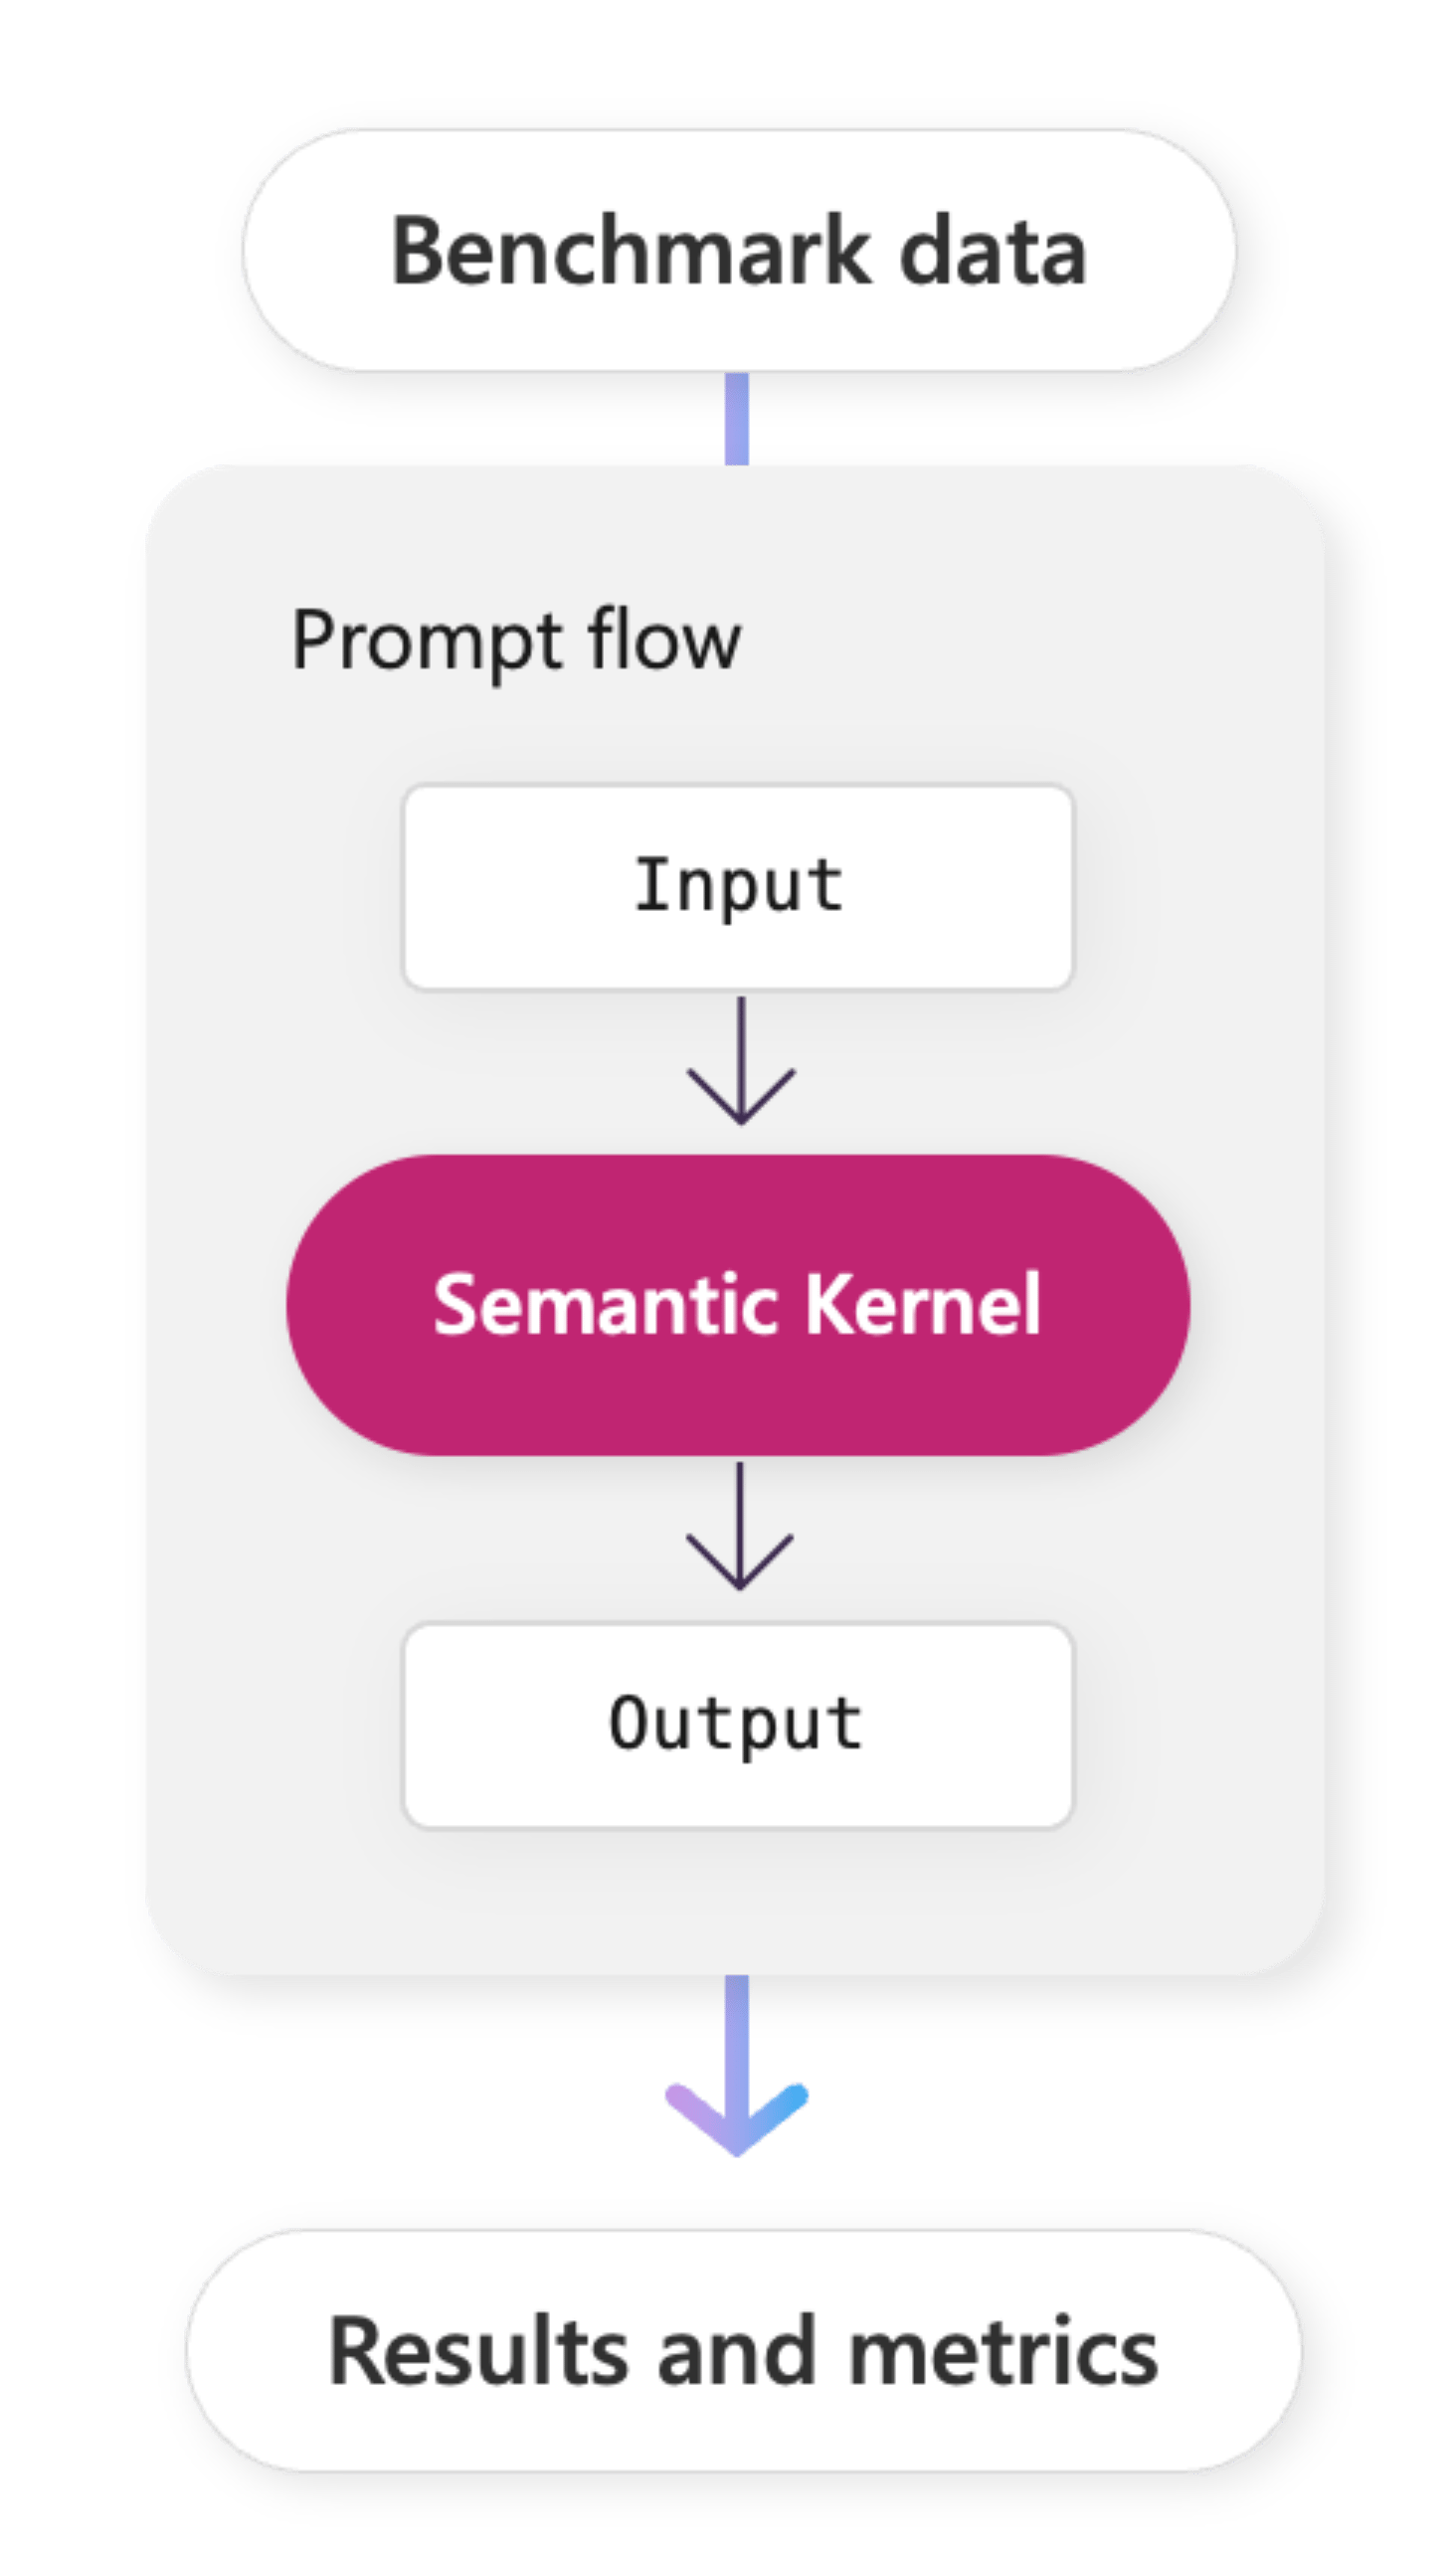

In [9]:
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
image_path = './images/semantic-kernel-in-prompt-flow-1.png'
data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)

In [10]:
response = client.chat.completions.create(
    model=azure_openai_deployment_name,
    messages=[
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": "Describe this picture:" 
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": data_url 
                }
            }
        ] } 
    ],
    
)
print(response)
print(response.choices[0].message.content)
print("Usage Information:")
print(f"Cached Tokens: {response.usage.prompt_tokens_details.cached_tokens}")
print(f"Completion Tokens: {response.usage.completion_tokens}")
print(f"Prompt Tokens: {response.usage.prompt_tokens}")
print(f"Total Tokens: {response.usage.total_tokens}")

ChatCompletion(id='chatcmpl-Amd0V1QeEmGbu1u9PbiW23TuO0kr9', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='It is a simple, vertical flowchart showing how data moves through a “prompt flow” to produce results. At the top, a rounded rectangle labeled “Benchmark data” feeds into a larger box titled “Prompt flow.” Inside that box, the order is:  \n• A smaller rectangle labeled “Input,”  \n• An arrow pointing down to a magenta oval labeled “Semantic Kernel,”  \n• Another arrow pointing down to a smaller rectangle labeled “Output.”  \nFrom there, an arrow leads to a rounded rectangle at the bottom labeled “Results and metrics.” The overall diagram visually represents the flow from benchmark data in, through the semantic kernel, and out to final results and measurements.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_mat